In [ ]:
import sys
sys.path.append("..")
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# SVD Helper Logic

In [ ]:
from sklearn.decomposition import TruncatedSVD
from train_test_split import DatasetDivision
import pandas as pd
from scipy.stats import linregress
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix, vstack
import concurrent.futures as cf


def mean_center_sparse(sparse_matrix: csr_matrix | csc_matrix, means: np.ndarray = None, counts: np.ndarray = None) -> tuple[csr_matrix, np.ndarray, np.ndarray]:
    """Mean-center each <primary-index> of a sparse CSR/CSP matrix (non-zero entries only)."""
    matrix: csr_matrix | csc_matrix = sparse_matrix.copy().astype(float)

    if isinstance(matrix, csc_matrix):
        secondary_axis = 1
        primary_axis = 0
    else:
        secondary_axis = 0
        primary_axis = 1

    if means is None or counts is None:
        # Compute column sums and counts of non-zero entries
        sums = matrix.sum(axis=primary_axis).A1
        counts = np.diff(matrix.indptr)

        with np.errstate(divide='ignore', invalid='ignore'):
            means = np.divide(sums, counts, where=counts != 0)

    # Subtract column mean from each non-zero in that column
    for i in range(matrix.shape[secondary_axis]):
        start = matrix.indptr[i]
        end = matrix.indptr[i + 1]
        if counts[i] > 0:
            matrix.data[start:end] = matrix.data[start:end].astype(float) - means[i]

    return matrix.tocsr(), means, counts


def global_mean_center_sparse(sparse_matrix: csr_matrix, mean: float = None) -> tuple[csr_matrix, float]:
    """Mean-center a sparse CSR matrix globally (all non-zero entries)."""
    matrix = sparse_matrix.copy()

    if mean is None:
        mean = matrix.data.mean()

    matrix.data = matrix.data.astype(float) - mean
    return matrix, mean


def lookup_predicted_ratings(df_unseen: pd.DataFrame, X_pred: np.ndarray) -> pd.Series:
    predicted_ratings = df_unseen.apply(
        lambda row: X_pred[int(row["user_id"]), int(row["item_id"])], axis=1
    )
    return predicted_ratings


def perform_svd_prediction(dataset: DatasetDivision, use_seen_in_svd: bool = False):
    # Combine seen data if applicable
    if use_seen_in_svd:
        X_train = vstack((dataset.X_train,dataset.X_test_seen))
    else:
        X_train = dataset.X_train

    for center_mechanism in ["global", "none"]:
        # Center data
        if center_mechanism == "user":  # User-centered
            train_dataset, _, _ = mean_center_sparse(X_train)
            test_dataset, _, _ = mean_center_sparse(dataset.X_test_seen)
        elif center_mechanism == "item":  # Item-centered
            train_dataset, item_means, item_counts = mean_center_sparse(X_train.tocsc())
            test_dataset, _, _ = mean_center_sparse(dataset.X_test_seen.tocsc(), item_means, item_counts)
        elif center_mechanism == "global":  # Global mean-centered
            train_dataset, global_mean = global_mean_center_sparse(X_train)
            test_dataset, _ = global_mean_center_sparse(dataset.X_test_seen, global_mean)
        else:
            train_dataset = X_train
            test_dataset = dataset.X_test_seen

        for k in [5, 10, 20, 50, 100]:
            truncated_svd = TruncatedSVD(n_components=k, random_state=42)
            # Fit
            truncated_svd.fit(train_dataset)

            # Predict
            X_reduced = truncated_svd.transform(test_dataset)

            def inverse_transform_batch(data_batch):
                return truncated_svd.inverse_transform(data_batch)

            batch_size = 10000
            n_rows = X_reduced.shape[0]
            batches = [X_reduced[i:min(i + batch_size, n_rows)] for i in range(0, n_rows, batch_size)]
            with cf.ThreadPoolExecutor() as executor:
                test_pred_batches = list(executor.map(inverse_transform_batch, batches))

            test_pred = np.vstack(test_pred_batches)

            # Report
            prediction_name = f"pred_rating_{center_mechanism}_k{k}"
            dataset.df_test_unseen[prediction_name] = lookup_predicted_ratings(
                dataset.df_test_unseen, test_pred
            )
            stats = linregress(dataset.df_test_unseen["rating"], dataset.df_test_unseen[prediction_name])
            print(f"{prediction_name:<23} R² = {stats.rvalue ** 2:.4f}")

            # Checkpoint results
            dataset.save_to_pickle()


# Train Test Split Logic

In [ ]:
import pickle
from dataclasses import dataclass
import pandas as pd
import os
from scipy.sparse._csr import csr_matrix
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from scipy import sparse


@dataclass
class DatasetDivision:
    dataset_name: str
    df_train: pd.DataFrame
    df_test_seen: pd.DataFrame
    df_test_unseen: pd.DataFrame
    X_train: csr_matrix
    X_test_seen: csr_matrix
    X_test_unseen: csr_matrix

    def save_to_pickle(self, base_dir: str ="."):
        os.makedirs(base_dir, exist_ok=True)
        path = os.path.join(base_dir, f"{self.dataset_name}_tts.pkl")
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load_from_pickle(cls, dataset_name: str, base_dir: str =".") -> "DatasetDivision":
        path = os.path.join(base_dir, f"{dataset_name}_tts.pkl")
        with open(path, "rb") as f:
            return pickle.load(f)


def divide_dataset(df: pd.DataFrame, dataset_name: str):
    df = df[~df["user_id"].isnull()].copy()
    df["item_id"], unique_item_ids = pd.factorize(df["item_id"])
    n_items = len(unique_item_ids)

    # Train Test Split
    print("Performing TTS")
    gss = GroupShuffleSplit(n_splits = 1, train_size=0.75, random_state=12)
    groups = gss.split(df, groups=df["user_id"])
    train_indices = []
    test_indices = []
    for fold_train_indices, fold_test_indices in groups:
        train_indices = fold_train_indices
        test_indices = fold_test_indices
    df_train = df.iloc[train_indices].copy()
    df_test = df.iloc[test_indices].copy()

    # Sparsify Train
    df_train["user_id"], unique_train_user_ids = pd.factorize(df_train["user_id"])
    n_training_users = len(unique_train_user_ids)
    X_train = sparse.csr_matrix(
        (df_train["rating"], (df_train["user_id"], df_train["item_id"])),
        shape=(n_training_users, n_items)
    )

    # Seen Unseen Split
    df_test["user_id"], unique_test_user_ids = pd.factorize(df_test["user_id"])
    n_testing_users = len(unique_test_user_ids)
    user_rating_counts = df_test.groupby("user_id")["rating"].count()
    users_with_one_rating = user_rating_counts[user_rating_counts == 1].index
    df_test = df_test[~df_test["user_id"].isin(users_with_one_rating)]
    df_test_seen, df_test_unseen = train_test_split(df_test, test_size=0.25, stratify=df_test["user_id"])

    # Sparsify Seen
    X_test_seen = sparse.csr_matrix(
        (df_test_seen["rating"], (df_test_seen["user_id"], df_test_seen["item_id"])),
        shape=(n_testing_users, n_items)
    )

    X_test_unseen = sparse.csr_matrix(
        (df_test_unseen["rating"], (df_test_unseen["user_id"], df_test_unseen["item_id"])),
        shape=(n_testing_users, n_items)
    )

    dataset_division = DatasetDivision(
        dataset_name=dataset_name,
        df_train=df_train,
        df_test_seen=df_test_seen,
        df_test_unseen=df_test_unseen,
        X_train=X_train,
        X_test_seen=X_test_seen,
        X_test_unseen=X_test_unseen
    )
    dataset_division.save_to_pickle()
    return dataset_division


def sparse_matrix_to_df(sparse_matrix: csr_matrix) -> pd.DataFrame:
    coo = sparse_matrix.tocoo()
    return pd.DataFrame({
        "user_id": coo.row,
        "item_id": coo.col,
        "rating": coo.data
    })


def df_to_sparse_matrix(df: pd.DataFrame) -> csr_matrix:
    df["item_id"], unique_items = pd.factorize(df["item_id"])
    n_items = len(unique_items)
    df["user_id"], unique_users = pd.factorize(df["user_id"])
    n_users = len(unique_users)
    sparse_matrix = csr_matrix(
        (df["rating"], (df["user_id"], df["item_id"])),
        shape=(n_users, n_items)
    )
    return sparse_matrix


# Predictions

In [2]:
RESPLIT_DATASETS = False

In [3]:
if RESPLIT_DATASETS:
    print("Resplitting datasets...")
    bgg_df = pd.read_feather("../Data/boardgamegeek.feather")
    divide_dataset(bgg_df, "bgg")
    movie_df = pd.read_feather("../Data/movielens_25m.feather")
    divide_dataset(movie_df, "movielens")
    yahoo_df = pd.read_feather("../Data/yahoo_r2_songs.subsampled.feather")
    divide_dataset(yahoo_df, "yahoo_songs")
    np_df = pd.read_feather("../Data/netflix_prize.feather")
    divide_dataset(np_df, "netflix_prize")
    del movie_df, bgg_df, yahoo_df, np_df
    _ = gc.collect()
else:
    print("Using existing saved datasets...")

Using existing saved datasets...


In [4]:
bgg_tts = DatasetDivision.load_from_pickle("bgg")
print("BoardGameGeek Dataset\n")
print("Without seen data:")
perform_svd_prediction(bgg_tts)
print("\nWith seen data:")
perform_svd_prediction(bgg_tts, use_seen_in_svd=True)
del bgg_tts
_ = gc.collect()

BoardGameGeek Dataset

Without seen data:
pred_rating_global_k5   R² = 0.1360
pred_rating_global_k10  R² = 0.1428
pred_rating_global_k20  R² = 0.1426
pred_rating_global_k50  R² = 0.1289
pred_rating_global_k100 R² = 0.1157
pred_rating_none_k5     R² = 0.0238
pred_rating_none_k10    R² = 0.0287
pred_rating_none_k20    R² = 0.0288
pred_rating_none_k50    R² = 0.0187
pred_rating_none_k100   R² = 0.0092

With seen data:
pred_rating_global_k5   R² = 0.1350
pred_rating_global_k10  R² = 0.1411
pred_rating_global_k20  R² = 0.1403
pred_rating_global_k50  R² = 0.1262
pred_rating_global_k100 R² = 0.1119
pred_rating_none_k5     R² = 0.0238
pred_rating_none_k10    R² = 0.0286
pred_rating_none_k20    R² = 0.0275
pred_rating_none_k50    R² = 0.0173
pred_rating_none_k100   R² = 0.0082


In [5]:
movielens_tts = DatasetDivision.load_from_pickle("movielens")
print("MovieLens Dataset\n")
perform_svd_prediction(movielens_tts)
print("\nWith seen data:")
perform_svd_prediction(movielens_tts, use_seen_in_svd=True)
del movielens_tts
_ = gc.collect()

MovieLens Dataset

pred_rating_global_k5   R² = 0.1906
pred_rating_global_k10  R² = 0.2166
pred_rating_global_k20  R² = 0.2400
pred_rating_global_k50  R² = 0.2526
pred_rating_global_k100 R² = 0.2476
pred_rating_none_k5     R² = 0.0383
pred_rating_none_k10    R² = 0.0532
pred_rating_none_k20    R² = 0.0629
pred_rating_none_k50    R² = 0.0687
pred_rating_none_k100   R² = 0.0558

With seen data:
pred_rating_global_k5   R² = 0.1900
pred_rating_global_k10  R² = 0.2158
pred_rating_global_k20  R² = 0.2381
pred_rating_global_k50  R² = 0.2492
pred_rating_global_k100 R² = 0.2420
pred_rating_none_k5     R² = 0.0383
pred_rating_none_k10    R² = 0.0531
pred_rating_none_k20    R² = 0.0628
pred_rating_none_k50    R² = 0.0659
pred_rating_none_k100   R² = 0.0503


In [6]:
netflix_prixe_tts = DatasetDivision.load_from_pickle("netflix_prize")
print("Netflix Prize Dataset\n")
perform_svd_prediction(netflix_prixe_tts)
print("\nWith seen data:")
perform_svd_prediction(netflix_prixe_tts, use_seen_in_svd=True)
del netflix_prixe_tts
_ = gc.collect()

Netflix Prize Dataset

pred_rating_global_k5   R² = 0.1730
pred_rating_global_k10  R² = 0.1890
pred_rating_global_k20  R² = 0.1946
pred_rating_global_k50  R² = 0.1849
pred_rating_global_k100 R² = 0.1667
pred_rating_none_k5     R² = 0.0405
pred_rating_none_k10    R² = 0.0490
pred_rating_none_k20    R² = 0.0601
pred_rating_none_k50    R² = 0.0654
pred_rating_none_k100   R² = 0.0479

With seen data:
pred_rating_global_k5   R² = 0.1723
pred_rating_global_k10  R² = 0.1878
pred_rating_global_k20  R² = 0.1930
pred_rating_global_k50  R² = 0.1826
pred_rating_global_k100 R² = 0.1640
pred_rating_none_k5     R² = 0.0404
pred_rating_none_k10    R² = 0.0490
pred_rating_none_k20    R² = 0.0598
pred_rating_none_k50    R² = 0.0621
pred_rating_none_k100   R² = 0.0432


In [7]:
yahoo_songs_tss = DatasetDivision.load_from_pickle("yahoo_songs")
print("Yahoo Dataset\n")
print("Without seen data:")
perform_svd_prediction(yahoo_songs_tss)
print("\nWith seen data:")
perform_svd_prediction(yahoo_songs_tss, use_seen_in_svd=True)
del yahoo_songs_tss
_ = gc.collect()

Yahoo Dataset

Without seen data:
pred_rating_global_k5   R² = 0.0702
pred_rating_global_k10  R² = 0.0776
pred_rating_global_k20  R² = 0.0778
pred_rating_global_k50  R² = 0.0743
pred_rating_global_k100 R² = 0.0695
pred_rating_none_k5     R² = 0.0236
pred_rating_none_k10    R² = 0.0261
pred_rating_none_k20    R² = 0.0268
pred_rating_none_k50    R² = 0.0231
pred_rating_none_k100   R² = 0.0227

With seen data:
pred_rating_global_k5   R² = 0.0704
pred_rating_global_k10  R² = 0.0764
pred_rating_global_k20  R² = 0.0759
pred_rating_global_k50  R² = 0.0733
pred_rating_global_k100 R² = 0.0681
pred_rating_none_k5     R² = 0.0234
pred_rating_none_k10    R² = 0.0257
pred_rating_none_k20    R² = 0.0261
pred_rating_none_k50    R² = 0.0224
pred_rating_none_k100   R² = 0.0223


In [11]:
bgg_tts = DatasetDivision.load_from_pickle("bgg")
movielens_tts = DatasetDivision.load_from_pickle("movielens")
netflix_prixe_tts = DatasetDivision.load_from_pickle("netflix_prize")
yahoo_songs_tss = DatasetDivision.load_from_pickle("yahoo_songs")

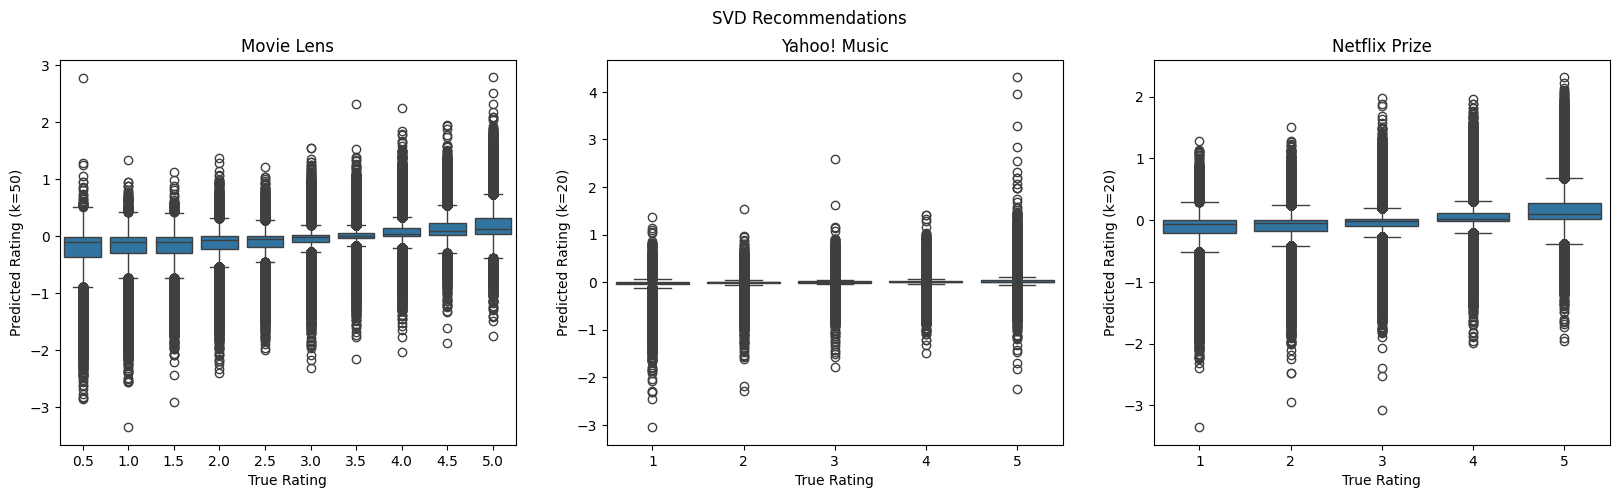

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle("SVD Recommendations")
movielens_ax: plt.Axes = axes[0]
yahoo_ax: plt.Axes = axes[1]
np_ax: plt.Axes = axes[2]

sns.boxplot(movielens_tts.df_test_unseen[~movielens_tts.df_test_unseen["pred_rating_global_k50"].isna()], x="rating", y="pred_rating_global_k50", ax=movielens_ax)
movielens_ax.set_xlabel("True Rating")
movielens_ax.set_ylabel("Predicted Rating (k=50)")
movielens_ax.set_title("Movie Lens")

sns.boxplot(yahoo_songs_tss.df_test_unseen[~yahoo_songs_tss.df_test_unseen["pred_rating_global_k20"].isna()], x="rating", y="pred_rating_global_k20", ax=yahoo_ax)
yahoo_ax.set_xlabel("True Rating")
yahoo_ax.set_ylabel("Predicted Rating (k=20)")
yahoo_ax.set_title("Yahoo! Music")

sns.boxplot(netflix_prixe_tts.df_test_unseen[~netflix_prixe_tts.df_test_unseen["pred_rating_global_k20"].isna()], x="rating", y="pred_rating_global_k20", ax=np_ax)
np_ax.set_xlabel("True Rating")
np_ax.set_ylabel("Predicted Rating (k=20)")
np_ax.set_title("Netflix Prize")


plt.show()

In [17]:
def plot_rating_count_hists(datasets: list[DatasetDivision]):
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), sharex=True, sharey=False)
    if num_datasets == 1:
        axes = [axes]
    fig.suptitle("Prediction Counts By User (Baseline vs SVD k=20)", fontsize=18)

    for col_idx, dataset in enumerate(datasets):
        df = dataset.df_test_unseen
        dataset_name = dataset.dataset_name
        ax = axes[col_idx]

        # Baseline: count of ratings per user (all test-unseen)
        baseline_counts = df.groupby("user_id")["item_id"].count()

        # SVD k=20: count of non-NaN predictions per user
        pred_col = "pred_rating_global_k20"
        svd_counts = df[~df[pred_col].isna()].groupby("user_id")[pred_col].count()

        # Align indices for plotting
        all_user_ids = df["user_id"].unique()
        baseline_counts = pd.Series(baseline_counts, index=all_user_ids).fillna(0).astype(int)
        svd_counts = pd.Series(svd_counts, index=all_user_ids).fillna(0).astype(int)

        sns.histplot(baseline_counts, bins=15, log_scale=True, ax=ax, color="red", label="Baseline", alpha=0.5)
        sns.histplot(svd_counts, bins=15, log_scale=True, ax=ax, color="blue", label="SVD k=20", alpha=0.5)

        ax.set_title(dataset_name, fontsize=14)
        ax.set_xlabel("Number of Predictions", fontsize=12)
        ax.set_ylabel("User Count\n(Log Scale)", fontsize=11)
        ax.tick_params(axis='both', labelsize=10)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


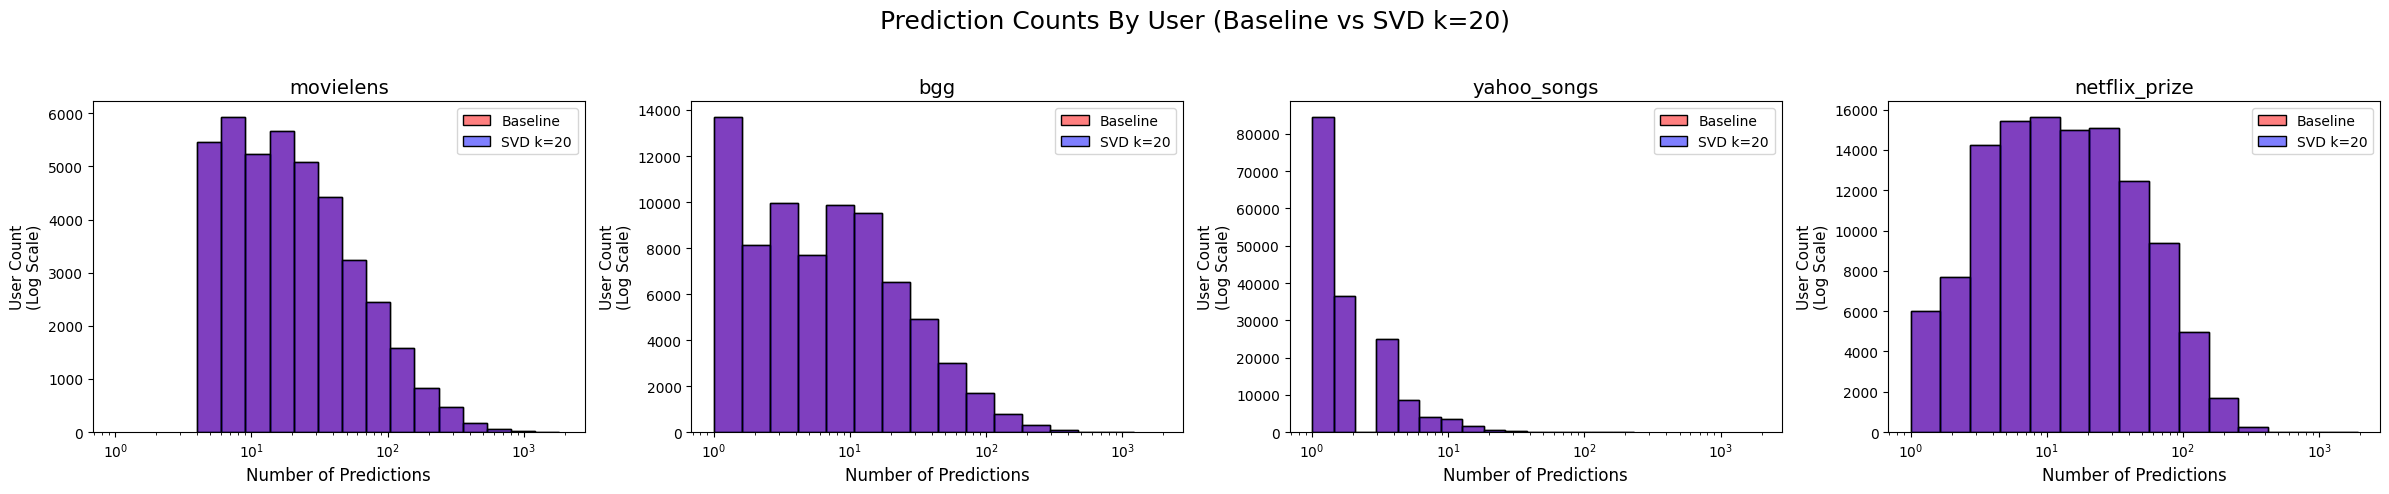

In [18]:
plot_rating_count_hists([movielens_tts, bgg_tts, yahoo_songs_tss, netflix_prixe_tts])

# Unit Tests

In [ ]:
import unittest
from scipy.sparse import csr_matrix, csc_matrix
import numpy as np
import pandas as pd

from svd_helpers import (
    mean_center_sparse,
    global_mean_center_sparse,
    lookup_predicted_ratings
)

class TestSVDHelpers(unittest.TestCase):
    def test__mean_center_sparse__csr_user_averages(self):
        test_matrix = csr_matrix([[1, 0, 3], [0, 4, 0], [5, 0, 6]])
        centered_matrix, means, counts = mean_center_sparse(test_matrix)
        assert np.allclose(means, np.array([2, 4, 5.5]), 0.001)
        assert np.allclose(counts, np.array([2, 1, 2]), 0.001)
        assert np.allclose(centered_matrix.toarray(), np.array([[-1, 0, 1],[0, 0, 0],[-0.5, 0, 0.5]]), 0.001)

    def test__mean_center_sparse__csc_item_averages(self):
        test_matrix = csc_matrix([[1, 0, 3], [0, 4, 0], [5, 0, 6]])
        centered_matrix, means, counts = mean_center_sparse(test_matrix)
        assert np.allclose(means, np.array([3, 4, 4.5]), 0.001)
        assert np.allclose(counts, np.array([2, 1, 2]), 0.001)
        assert np.allclose(centered_matrix.toarray(), np.array([[-2, 0, -1.5],[0, 0, 0],[2, 0, 1.5]]), 0.001)

    def test_global_mean_center_sparse(self):
        test_matrix = csc_matrix([[1, 0, 3], [0, 4, 0], [5, 0, 6]])
        centered_matrix, mean = global_mean_center_sparse(test_matrix)
        assert np.isclose(mean, 3.8, 0.001)
        assert np.allclose(centered_matrix.toarray(), np.array([[-2.8, 0, -0.8],[0, 0.2, 0],[1.2, 0, 2.2]]), 0.001)

    def test_lookup_predicted_ratings(self):
        unseen_df = pd.DataFrame({
            "user_id": [0, 1, 2],
            "item_id": [2, 1, 0]
        })
        test_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        predicted_ratings = lookup_predicted_ratings(unseen_df, test_matrix)
        assert np.allclose(predicted_ratings.values, np.array([3, 5, 7]), 0.001)

unittest.main()